# Στοιχεία Ομάδας

##M.C.25


*   Νεόφυτος Παπασάββας 03115702
*   Ειρήνη Παπαπαδοπούλου 03115703

# Σύνολο δεδομένων CIFAR-100
![alt text](https://datarepository.wolframcloud.com/resources/images/69f/69f1e629-81e6-4eaa-998f-f6734fcd2cb3-io-4-o.en.gif)

To [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) όπως και το CIFAR-10 που είδαμε στο εργαστήριο είναι επισημειωμένα υποσύνολα του συνόλου δεδομένων “80 million tiny images”. Τα συνέλλεξαν οι Alex Krizhevsky (πρώτος συγγραφέας του [AlexNet - 2012](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)), Vinod Nair (πρώτος συγγραφέας των [ReLU - 2010](https://www.cs.toronto.edu/~hinton/absps/reluICML.pdf)) και ο Geoffrey Hinton.

Το CIFAR-100 αποτελείται από **60000 έγχρωμες εικόνες των 32x32 pixel χωρισμένες σε 100 κατηγορίες**. Σε κάθε κατηγορία αντιστοιχούν 500 εικόνες εκπαίδευσης και 100 εικόνες ελέγχου, δηλαδή το train-test split είναι προκαθορισμένο. **Κάθε μια από τις 100 κατηγορίες του CIFAR-100 ανήκει και σε μια από 20 υπερκατηγορίες**, για παράδειγμα οι κατηγορίες “maple”, “oak”, “palm”, “pine” και “willow” ανήκουν στην υπερκατηγορία “trees”. Κάθε εικόνα έχει δύο ετικέτες, μια “fine” που δείχνει την κατηγορία της και μια “coarse” που δείχνει την υπερκατηγορία της. **Θα δουλέψουμε αποκλειστικά με τις κατηγορίες ("fine")**.

**To CIFAR-100 είναι, όπως είναι αναμενόμενο, σημαντικά πιο δύσκολο dataset από το CIFAR-10.** Μέχρι το 2019, η απόδοση των συστημάτων state-of-the-art στο CIFAR-10 ήταν ορθότητα (accuracy) [99.00%](https://benchmarks.ai/cifar-10https://) (GPipe: Efficient Training of Giant Neural Networks using Pipeline Parallelism) ενώ στο CIFAR-100 ήταν [91.70%](https://benchmarks.ai/cifar-100https://)
(EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks)	

In [1]:
!sudo pip install --upgrade pip
!sudo pip install --upgrade tensorflow

     |████████████████████████████████| 1.4MB 8.6MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.1.0)


## Εισαγωγή και επισκόπηση του συνόλου δεδομένων

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals # legacy compatibility

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


In [0]:
DATASET_SIZE = 60000
# select from from_list elements with index in index_list
def select_from_list(from_list, index_list):
  filtered_list= [from_list[i] for i in index_list]
  return(filtered_list)

# append in filtered_list the index of each element of unfilterd_list if it exists in in target_list
def get_ds_index(unfiliterd_list, target_list):
  index = 0
  filtered_list=[]
  for i_ in unfiliterd_list:
    if i_[0] in target_list:
      filtered_list.append(index)
    index += 1
  return(filtered_list)

def create_our_dataset(x_dataset, target_list):
  x = []
  y = []
  for image, label in x_dataset:
    if label.numpy() in target_list:
      y.append((label.numpy()))
      x.append((image.numpy()))
  dataset = tf.data.Dataset.from_tensor_slices((x,y))
  return dataset

# select a url for a unique subset of CIFAR-100 with 20, 40, 60, or 80 classes
def select_classes_number(classes_number = 20):
  cifar100_20_classes_url = "https://pastebin.com/raw/nzE1n98V"
  cifar100_40_classes_url = "https://pastebin.com/raw/zGX4mCNP"
  cifar100_60_classes_url = "https://pastebin.com/raw/nsDTd3Qn"
  cifar100_80_classes_url = "https://pastebin.com/raw/SNbXz700"
  if classes_number == 20:
    return cifar100_20_classes_url
  elif classes_number == 40:
    return cifar100_40_classes_url
  elif classes_number == 60:
    return cifar100_60_classes_url
  elif classes_number == 80:
    return cifar100_80_classes_url
  else:
    return -1

IMG_SIZE = 192
def resize_image(image, label):
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

#to create a TFRecord

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(image, label, image_shape):
    feature = {
        'image': _bytes_feature(image),
        'label': _int64_feature(label),
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
    }
    #  Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

Δημιουργούμε το μοναδικό dataset της ομάδας μας:

In [0]:
# REPLACE WITH YOUR TEAM NUMBER
team_seed = 65

Στο επόμενο κελί μπορείτε να διαλέξετε το πλήθος των κατηγορίων σας: 20 (default), 40, 60 ή 80.

In [0]:
# select the number of classes
CLASSES_NUM = 20
cifar100_classes_url = select_classes_number(CLASSES_NUM)

In [0]:
team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None)
CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt', sep=',', header=None).astype(str).values.tolist()[0]

our_index = team_classes.iloc[team_seed,:].values.tolist()
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)

In [7]:
# print our classes
print(our_classes)

[' boy', ' bus', ' can', ' castle', ' chair', ' cup', ' dolphin', ' lawn_mower', ' lizard', ' man', ' palm_tree', ' shrew', ' skyscraper', ' snake', ' spider', ' sweet_pepper', ' table', ' telephone', ' tiger', ' whale']


In [0]:
train, test = tfds.load(name = 'cifar100', split = ['train', 'test'], as_supervised=True)
assert isinstance(train, tf.data.Dataset)
assert isinstance(test, tf.data.Dataset)
train_ds = create_our_dataset(train, our_index)
test_ds = create_our_dataset(test, our_index)

In [0]:
validation_percentage = 0.15
val_size = round(validation_percentage * len(list(train_ds)))
val_x = []
val_y = []
for image, label in list(train_ds)[-val_size:]:
  val_x.append(image)
  val_y.append(label)
validation_ds = tf.data.Dataset.from_tensor_slices((val_x, val_y))

train_x = []
train_y = []
for image, label in list(train_ds)[:-val_size]:
  train_x.append(image)
  train_y.append(label)
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))

In [10]:
# summarize loaded dataset
train_len = len(list(train_ds))
validation_len = len(list(validation_ds))
test_len = len(list(test_ds))
print('Train:', train_len)
print('Validation:', validation_len)
print('Test:', test_len)

Train: 8500
Validation: 1500
Test: 2000


Τώρα θα δημιουργήσουμε 16 ΤFRecords για το train set και 3 TFRecords για το validation set αφού τα έχουμε ήδη χωρίσει.

In [11]:
TRAIN_SHARDS = (16*CLASSES_NUM/20)
VAL_SHARDS = (3*CLASSES_NUM/20)
shared_size_train = np.math.ceil(1.0 * len(list(train_ds)) / TRAIN_SHARDS)
shared_size_val = np.math.ceil(1.0 * len(list(validation_ds)) / VAL_SHARDS)
print(shared_size_train)
print(shared_size_val)

532
500


In [0]:
train_ds = train_ds.batch(shared_size_train)
validation_ds = validation_ds.batch(shared_size_val)

In [0]:
#write to the file
def write_tfrecord(ds, ds_name):
  for shard, (image,label) in enumerate(ds):
    shard_size = image.numpy().shape[0]
    filename = "./cifar100_" + ds_name + "{:02d}-{}.tfrec".format(shard, shard_size)
    with tf.io.TFRecordWriter(filename) as writer:
      for i in range(shard_size):
          img_array = tf.keras.preprocessing.image.img_to_array(image[i])
          img_array = (img_array/255.0)
          #img_array = tf.image.resize(img_array, (IMG_SIZE, IMG_SIZE))
          #img_array = tf.keras.preprocessing.image.random_zoom(img_array, (0.5,0.5),
          #                               row_axis=0,
          #                               col_axis=1)
          img_bytes = tf.io.serialize_tensor(img_array)
          image_shape = img_array.shape
          example = serialize_example(img_bytes, label[i], image_shape)
          writer.write(example)
      print("Wrote file {} containing {} records".format(filename, shard_size))    

In [14]:
write_tfrecord(train_ds, "train")
write_tfrecord(validation_ds, "val")

Wrote file ./cifar100_train00-532.tfrec containing 532 records
Wrote file ./cifar100_train01-532.tfrec containing 532 records
Wrote file ./cifar100_train02-532.tfrec containing 532 records
Wrote file ./cifar100_train03-532.tfrec containing 532 records
Wrote file ./cifar100_train04-532.tfrec containing 532 records
Wrote file ./cifar100_train05-532.tfrec containing 532 records
Wrote file ./cifar100_train06-532.tfrec containing 532 records
Wrote file ./cifar100_train07-532.tfrec containing 532 records
Wrote file ./cifar100_train08-532.tfrec containing 532 records
Wrote file ./cifar100_train09-532.tfrec containing 532 records
Wrote file ./cifar100_train10-532.tfrec containing 532 records
Wrote file ./cifar100_train11-532.tfrec containing 532 records
Wrote file ./cifar100_train12-532.tfrec containing 532 records
Wrote file ./cifar100_train13-532.tfrec containing 532 records
Wrote file ./cifar100_train14-532.tfrec containing 532 records
Wrote file ./cifar100_train15-520.tfrec containing 520 

In [0]:
train_filenames=tf.io.gfile.glob('cifar100_train*.tfrec')
val_filenames=tf.io.gfile.glob('cifar100_val*.tfrec')

In [0]:
def read_tfrecord(serialized_example):
    feature_description = {
        'image': tf.io.FixedLenFeature((), tf.string),
        'label': tf.io.FixedLenFeature((), tf.int64),
        'height': tf.io.FixedLenFeature((), tf.int64),
        'width': tf.io.FixedLenFeature((), tf.int64),
        'depth': tf.io.FixedLenFeature((), tf.int64)
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    
    image = tf.io.parse_tensor(example['image'], out_type = float)
    image_shape = [example['height'], example['width'], example['depth']]
    image = tf.reshape(image, image_shape)
    image = image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    return image, example['label']

Για να κάνουμε **Data Augmentation**:

In [0]:
def augmentation(image,label):
  image = tf.image.resize_with_crop_or_pad(image, int(IMG_SIZE*1.25), int(IMG_SIZE*1.25))
  image = tf.image.random_crop(image, size=[int(IMG_SIZE), int(IMG_SIZE), 3]) # Random crop
  image = tf.image.random_brightness(image, max_delta=0.01) # Random brightness
  #image = tf.image.flip_up_down(image)
  return image,label

In [0]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def get_batched_dataset(filenames, augment):
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.Dataset.list_files(filenames)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.interleave(tf.data.TFRecordDataset)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
  dataset = dataset.map(resize_image)
  if (augment):
    dataset = dataset.map(augmentation, num_parallel_calls=AUTOTUNE)
  print(len(list(dataset)))
  dataset = dataset.shuffle(buffer_size=train_len)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.repeat()
  dataset = dataset.prefetch(buffer_size=AUTOTUNE)
  return dataset

In [0]:
train_ds = get_batched_dataset(train_filenames, False)
train_ds_with_augmentation = train_ds
for i in range(5):
  train_ds_augmentation = get_batched_dataset(train_filenames, True)
  train_ds_with_augmentation = train_ds_with_augmentation.concatenate(train_ds_augmentation)
validation_ds = get_batched_dataset(val_filenames, False)

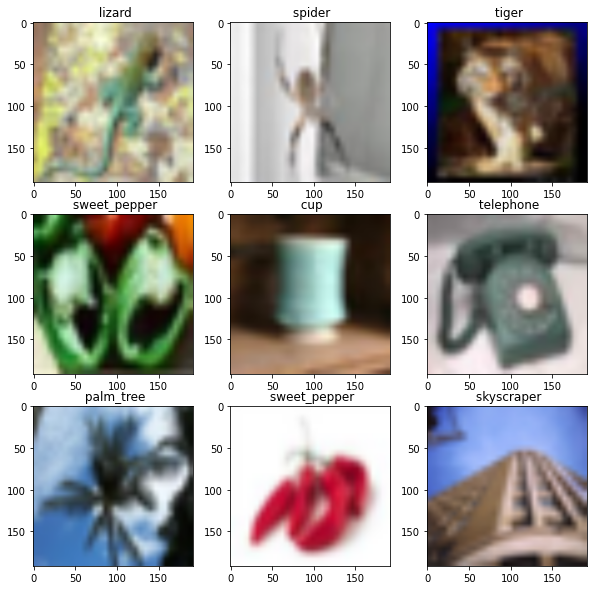

In [20]:
#plot train dataset with augmentation(crop and brightness)
plt.figure(figsize=(10,10))
for i, data in enumerate(train_ds_with_augmentation.take(9)):
     img = tf.keras.preprocessing.image.array_to_img(data[0][10])
     plt.subplot(3,3,i+1).set_title(CIFAR100_LABELS_LIST[data[1][10].numpy()])
     plt.imshow(img)
plt.show()

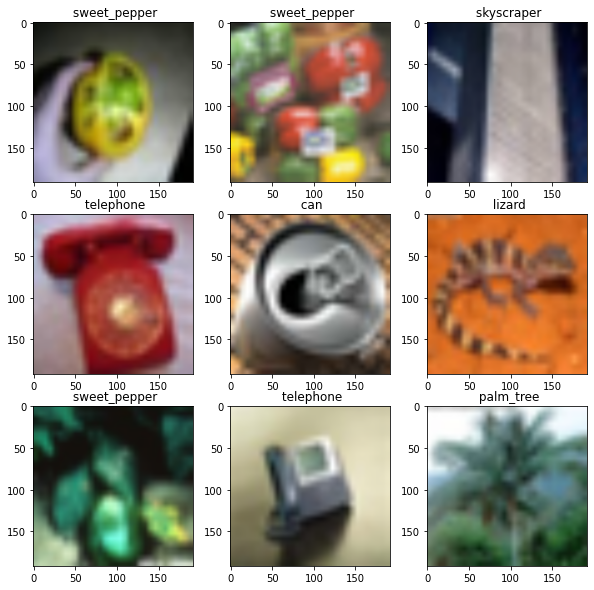

In [21]:
#plot train dataset without augmentation
plt.figure(figsize=(10,10))
for i, data in enumerate(train_ds.take(9)):
     img = tf.keras.preprocessing.image.array_to_img(data[0][10])
     plt.subplot(3,3,i+1).set_title(CIFAR100_LABELS_LIST[data[1][10].numpy()])
     plt.imshow(img)
plt.show()

In [0]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = image/255.0
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [0]:
test_ds = test_ds.map(resize_and_rescale).shuffle(train_len).batch(BATCH_SIZE).repeat()

## Συναρτήσεις εκπαίδευσης

Θα χρησιμοποιήσουμε την ιδιότητα data prefetch του tf2:

In [0]:
# https://www.tensorflow.org/guide/data_performance

# steps_per_epoch and validation_steps for training and validation: https://www.tensorflow.org/guide/keras/train_and_evaluate

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=5e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=4,
        verbose=1)
]

def train_model(model, epochs = 10, steps_per_epoch = 2, validation_steps = 1):
  history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=validation_steps)
  return(history)

def train_augmented_model(model, epochs = 10, steps_per_epoch = 2, validation_steps = 1):
  history = model.fit(train_ds_with_augmentation, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=validation_steps)
  return(history)

## Γραφικές παραστάσεις εκπαίδευσης και απόδοση στο σύνολο ελέγχου

In [0]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	plt.figure(figsize=(8, 8))
	plt.suptitle('Training Curves')
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='val')
	plt.legend(loc='upper right')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='val')
	plt.legend(loc='lower right')
	return plt
 
# print test set evaluation metrics
def model_evaluation(model, evaluation_steps):
	print('\nTest set evaluation metrics')
	loss0,accuracy0 = model.evaluate(test_ds, steps = evaluation_steps)
	print("loss: {:.2f}".format(loss0))
	print("accuracy: {:.2f}".format(accuracy0))

def model_report(model, history, evaluation_steps = 10):
	plt = summarize_diagnostics(history)
	plt.show()
	model_evaluation(model, evaluation_steps)

# Μοντέλα δικτύων

## Βελτίωση της επίδοσης με πειράματα

Στο συγκεκριμένο notebook έχουμε ρυθμίσει τις παραμέτρους με βάση το βέλτιστο αποτέλεσμα της μεταφοράς μάθησης με το VGG16. Οι παραμέτροι και τεχνικές για τη βελτιστοποίηση των άλλων μοντέλων μαζί με τις γραφικές και τα αποτελέσματα τους βρίσκονται στην αναφορά.

### Μεταφορά μάθησης:

In [0]:
# transfer learning: VGG16 trained on ImageNet without the top layer

def init_VGG16_model(summary):
  VGG16_MODEL=tf.keras.applications.VGG16(input_shape= IMG_SHAPE, include_top=False, weights='imagenet')

  # unfreeze conv layers
  VGG16_MODEL.trainable=True

  # Let's take a look to see how many layers are in the base model
  print("Number of layers in the base model: ", len(VGG16_MODEL.layers))

  # Fine-tune from this layer onwards
  #fine_tune_at = 14

  # Freeze all the layers before the `fine_tune_at` layer
  #for layer in VGG16_MODEL.layers[:fine_tune_at]:
  #  layer.trainable =  False

  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([VGG16_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [27]:
VGG16_MODEL = init_VGG16_model(summary = True)
VGG16_MODEL_history = train_model(VGG16_MODEL, 25, 40, 10)

58892288/58889256 [==============================] - 2s 0us/step
Number of layers in the base model:  19
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 512)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               51300     
Total params: 14,765,988
Trainable params: 14,765,988
Non-trainable params: 0
_________________________________________________________________
Train for 40 steps, validate for 10 steps
Epoch 1/25
40/40 [==============================] - 40s 995ms/step - loss: 2.5447 - accuracy: 0

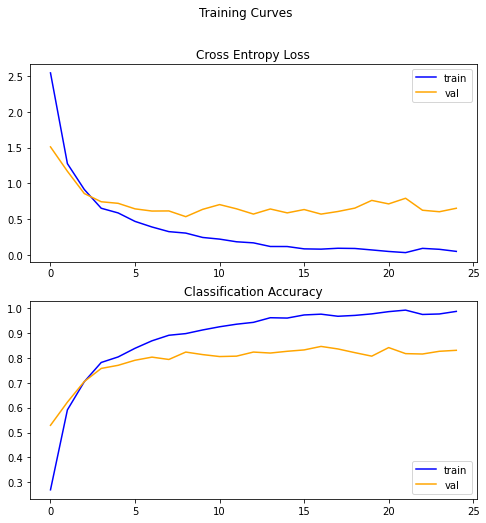


Test set evaluation metrics
30/30 [==============================] - 8s 277ms/step - loss: 0.6518 - accuracy: 0.8262
loss: 0.65
accuracy: 0.83


In [28]:
model_report(VGG16_MODEL, VGG16_MODEL_history, 30)

In [0]:
VGG16_MODEL = init_VGG16_model(summary = True)
VGG16_MODEL_history = train_augmented_model(VGG16_MODEL, 25, 40, 10)

In [0]:
model_report(VGG16_MODEL, VGG16_MODEL_history, 30)

In [0]:
# transfer learning: MobileNet V2 trained on ImageNet without the top layer
def init_MobileNetV2_model(summary):
  MobileNetV2_MODEL=tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE, include_top=False, weights='imagenet')

  # unfreeze conv layers
  MobileNetV2_MODEL.trainable=True

  # fine_tune_at = 100
  # # Freeze all the layers before the `fine_tune_at` layer
  # for layer in MobileNetV2_MODEL.layers[:fine_tune_at]:
  #     layer.trainable =  False

  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([MobileNetV2_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [0]:
MobileNetV2_MODEL = init_MobileNetV2_model(summary = True)
MobileNetV2_MODEL_history = train_model(MobileNetV2_MODEL, 25, 40, 10)

In [0]:
model_report(MobileNetV2_MODEL, MobileNetV2_MODEL_history, 30)

In [0]:
MobileNetV2_MODEL = init_MobileNetV2_model(summary = True)
MobileNetV2_MODEL_history = train_augmented_model(MobileNetV2_MODEL, 25, 40, 10)

In [0]:
model_report(MobileNetV2_MODEL, MobileNetV2_MODEL_history, 30)

In [0]:
# transfer learning: VGG19 trained on ImageNet without the top layer

def init_VGG19_model(summary):
  VGG19_MODEL=tf.keras.applications.VGG19(input_shape = IMG_SHAPE, include_top=False, weights='imagenet')

  # unfreeze conv layers
  VGG19_MODEL.trainable=True

  fine_tune_at = 14
  print("Number of layers in the base model: ", len(VGG19_MODEL.layers))
  # Freeze all the layers before the `fine_tune_at` layer
  for layer in VGG19_MODEL.layers[:fine_tune_at]:
      layer.trainable =  False

  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([VGG19_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00018), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [0]:
VGG19_MODEL = init_VGG19_model(summary = True)
VGG19_MODEL_history = train_model(VGG19_MODEL, 25, 40, 10)

In [0]:
model_report(VGG19_MODEL, VGG19_MODEL_history, 30)

In [0]:
VGG19_MODEL = init_VGG19_model(summary = True)
VGG19_MODEL_history = train_augmented_model(VGG19_MODEL, 25, 40, 10)

In [0]:
model_report(VGG19_MODEL, VGG19_MODEL_history, 30)

### Μοντέλα "from scratch"

In [0]:
# a simple CNN https://www.tensorflow.org/tutorials/images/cnn

def init_simple_model(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='elu', padding='same', input_shape=IMG_SHAPE))
  model.add(layers.Conv2D(32, (3, 3), activation='elu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv2D(32, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='elu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv2D(64, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='elu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='elu'))
  model.add(layers.Dropout(0.25))
  model.add(layers.Dense(100, activation='softmax'))
  model.compile(optimizer=tf.keras.optimizers.Adam(0.002), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [0]:
SIMPLE_MODEL = init_simple_model(summary = True)
SIMPLE_MODEL_history = train_model(SIMPLE_MODEL, 50, 45, 5)

In [0]:
SIMPLE_MODEL.metrics_names

In [0]:
model_report(SIMPLE_MODEL, SIMPLE_MODEL_history, 30)